# Structure-shift

We compare the following CSBMs and how their node2vec encoding changes:
- Constant CSBM
- CSBM-Hom
- CSBM-Het
- CSBM-Struct

We find the following assumptions useful:
- We compare nodes within the same embedding
- We compare the embeddings of the t-th chunk of nodes against the 1st chunk
- We use the same loader and optimizer for each epoch

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from csbms import MultiClassCSBM, StructureCSBM
from CSBMhet import CSBMhet
from CSBMhom import CSBMhom
from metrics import mmd_linear, mmd_max_rbf

import torch
from torch_geometric.nn import Node2Vec

In [2]:
n = 160
training_time = 20
T = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
csbm_zero = MultiClassCSBM(n =10*n, q_hom=0.05, q_het=0.01)
csbm_constant = MultiClassCSBM(n=n, q_hom=0.05, q_het=0.01)
#csbm_hom = CSBMhom(n=n)
csbm_het = CSBMhet(n=n, q_hom=0.05, q_het=0.01)
csbm_struct = StructureCSBM(n=n, q_hom=0.5, q_het=0.1)
csbms = [csbm_constant, csbm_het, csbm_struct]
#csbms.append(csbm_hom)
names = {csbm_zero: 'CSBM-Zero',
         csbm_constant: 'CSBM-Const',
         csbm_het: 'CSBM-Het',
         csbm_struct: 'CSBM-Struct'}

In [4]:
time_steps = list(range(T))
for t in range(2, T + 1):
    for csbm in csbms:
        csbm.evolve()
        print(f'{names[csbm]}'.ljust(12) + f'|t={t:02d}|'.ljust(5) + f'{len(csbm.data.edge_index[0])} edges'.rjust(20))

CSBM-Const  |t=02|           636 edges
CSBM-Het    |t=02|          1460 edges
CSBM-Struct |t=02|          7905 edges
CSBM-Const  |t=03|           963 edges
CSBM-Het    |t=03|          3807 edges
CSBM-Struct |t=03|         13723 edges
CSBM-Const  |t=04|          1280 edges
CSBM-Het    |t=04|          7868 edges
CSBM-Struct |t=04|         20439 edges
CSBM-Const  |t=05|          1618 edges
CSBM-Het    |t=05|         14287 edges
CSBM-Struct |t=05|         27763 edges
CSBM-Const  |t=06|          1927 edges
CSBM-Het    |t=06|         23630 edges
CSBM-Struct |t=06|         35458 edges
CSBM-Const  |t=07|          2256 edges
CSBM-Het    |t=07|         35966 edges
CSBM-Struct |t=07|         43816 edges
CSBM-Const  |t=08|          2575 edges
CSBM-Het    |t=08|         52107 edges
CSBM-Struct |t=08|         52492 edges
CSBM-Const  |t=09|          2902 edges
CSBM-Het    |t=09|         72153 edges
CSBM-Struct |t=09|         61517 edges
CSBM-Const  |t=10|          3225 edges
CSBM-Het    |t=10|       

In [5]:
def get_node_embeddings(csbm):
    data = csbm.data
    model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0).to(device)
    
    num_workers = 4 if sys.platform == 'linux' else 0
    loader = model.loader(batch_size=64, shuffle=True, num_workers=num_workers)
    optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01)

    N = len(csbm.X)
    train_mask = torch.zeros(n, dtype=torch.bool)
    train_mask[:int(0.8 * n)] = 1
    train_mask = train_mask.repeat(N // n)
    test_mask = torch.zeros(n, dtype=torch.bool)
    test_mask[-int(0.1 * n):] = 1
    test_mask = test_mask.repeat(N // n)
    
    def train():
        model.train()
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(loader)
    
    @torch.no_grad()
    def test():
        model.eval()
        z = model()
        acc = model.test(
            train_z=z[train_mask],
            train_y=data.y[train_mask],
            test_z=z[test_mask],
            test_y=data.y[test_mask],
            max_iter=150,
        )
        return acc
    max_loss = 0
    max_acc = 0
    for epoch in range(training_time):
        loss = train()
        max_loss = max(max_loss, loss)
        acc = test()
        max_acc = max(acc, max_acc)
    print(f'Loss: {max_loss:.3f}, Acc: {max_acc:.4f}')
    print(f'train_mask[0]: {train_mask[0]}, [n]: {train_mask[n]}, [-1]: {train_mask[-1]}')
    print(f'test_mask[0]: {test_mask[0]}, [n]: {test_mask[n]}, [-1]: {test_mask[-1]}')
    return model.embedding.weight.cpu().detach().numpy()

In [6]:
embeddings = []
for csbm in csbms:
    embeddings.append(get_node_embeddings(csbm))
emb_const, emb_het, emb_struct = embeddings
emb_zero = get_node_embeddings(csbm_zero)

Loss: 6.577, Acc: 0.0813
train_mask[0]: True, [n]: True, [-1]: False
test_mask[0]: False, [n]: False, [-1]: True
Loss: 7.147, Acc: 0.1062
train_mask[0]: True, [n]: True, [-1]: False
test_mask[0]: False, [n]: False, [-1]: True
Loss: 8.261, Acc: 0.1187
train_mask[0]: True, [n]: True, [-1]: False
test_mask[0]: False, [n]: False, [-1]: True
Loss: 8.931, Acc: 0.3500
train_mask[0]: True, [n]: True, [-1]: False
test_mask[0]: False, [n]: False, [-1]: True


In [7]:
def get_linear_mmd(embedding):
    differences = []
    for t in range(T):
        start = t * n
        end = start + n
        differences.append(mmd_linear(embedding[:n], embedding[start:end]))
    return differences

In [8]:
def get_rbf_mmd(embedding):
    differences = []
    for t in range(T):
        start = t * n
        end = start + n
        differences.append(mmd_max_rbf(embedding[:n], embedding[start:end]))
    return differences

In [9]:
mmds_linear_const = get_linear_mmd(emb_const)
#mmds_linear_hom = get_linear_mmd(emb_hom)
mmds_linear_het = get_linear_mmd(emb_het)
mmds_linear_struct = get_linear_mmd(emb_struct)
mmds_linear_zero = get_linear_mmd(emb_zero)

mmds_rbf_const = get_rbf_mmd(emb_const)
#mmds_rbf_hom = get_rbf_mmd(emb_hom)
mmds_rbf_het = get_rbf_mmd(emb_het)
mmds_rbf_struct = get_rbf_mmd(emb_struct)
mmds_rbf_zero = get_rbf_mmd(emb_zero)

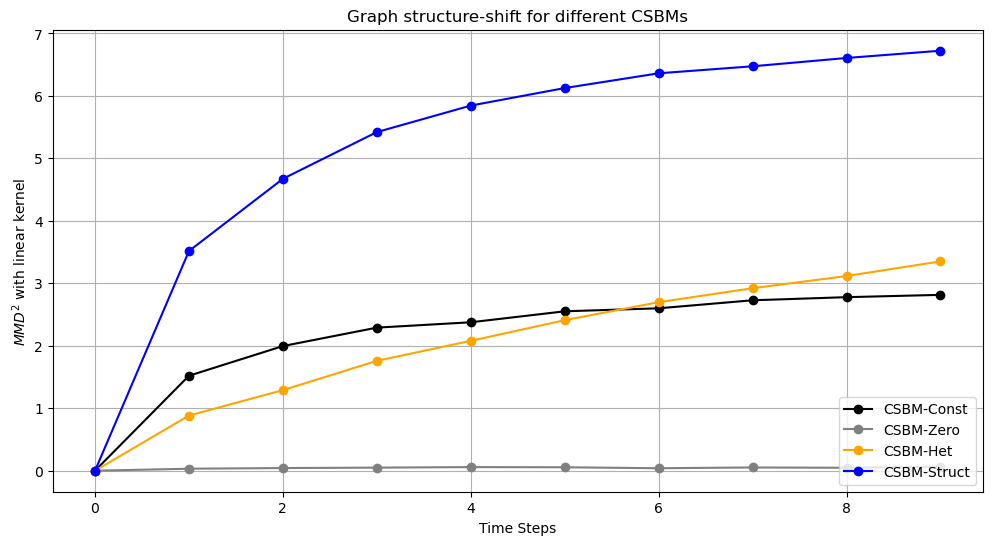

In [10]:
# plot
plt.figure(figsize=(12, 6))

plt.plot(time_steps, mmds_linear_const, marker='o', linestyle='-', color='black', label='CSBM-Const')
plt.plot(time_steps, mmds_linear_zero, marker='o', linestyle='-', color='gray', label='CSBM-Zero')
#plt.plot(time_steps, mmds_linear_hom, marker='o', linestyle='-', color='r', label='CSBM-Hom')
plt.plot(time_steps, mmds_linear_het, marker='o', linestyle='-', color='orange', label='CSBM-Het')
plt.plot(time_steps, mmds_linear_struct, marker='o', linestyle='-', color='blue', label='CSBM-Struct')

plt.title(r'Graph structure-shift for different CSBMs')
plt.xlabel('Time Steps')
plt.ylabel(r'$MMD^{2}$ with linear kernel')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig('structure_shift_linear.pdf', format='pdf')
plt.show()
plt.close()

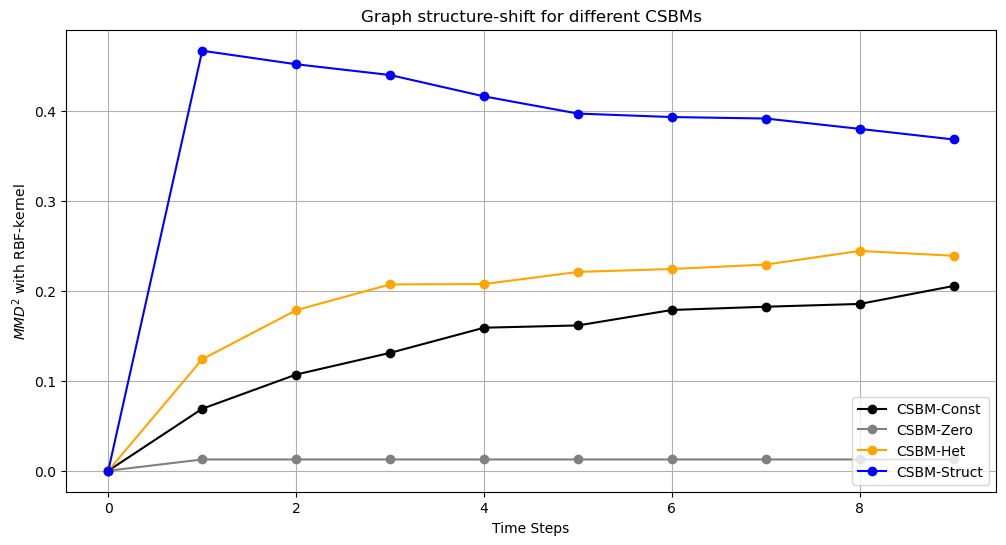

In [11]:
# plot
plt.figure(figsize=(12, 6))

plt.plot(time_steps, mmds_rbf_const, marker='o', linestyle='-', color='black', label='CSBM-Const')
plt.plot(time_steps, mmds_rbf_zero, marker='o', linestyle='-', color='gray', label='CSBM-Zero')
#plt.plot(time_steps, mmds_rbf_hom, marker='o', linestyle='-', color='r', label='CSBM-Hom')
plt.plot(time_steps, mmds_rbf_het, marker='o', linestyle='-', color='orange', label='CSBM-Het')
plt.plot(time_steps, mmds_rbf_struct, marker='o', linestyle='-', color='blue', label='CSBM-Struct')

plt.title(r'Graph structure-shift for different CSBMs')
plt.xlabel('Time Steps')
plt.ylabel(r'$MMD^{2}$ with RBF-kernel')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig('structure_shift_rbf.pdf', format='pdf')
plt.show()
plt.close()

In [12]:
csbms.append(csbm_zero)
for csbm in csbms:
    print('-' * 10 + names[csbm] + '-' * 10)
    print(f'|V|= {csbm.data.num_nodes}, |E|= {csbm.data.num_edges}, |E|/|V| = {(csbm.data.num_edges / csbm.data.num_nodes):.1f}')
    print(f'Possible edges: {(100 * csbm.data.num_edges / csbm.data.num_nodes ** 2):.2f}%\n')

----------CSBM-Const----------
|V|= 1600, |E|= 3225, |E|/|V| = 2.0
Possible edges: 0.13%

----------CSBM-Het----------
|V|= 1600, |E|= 96947, |E|/|V| = 60.6
Possible edges: 3.79%

----------CSBM-Struct----------
|V|= 1600, |E|= 70815, |E|/|V| = 44.3
Possible edges: 2.77%

----------CSBM-Zero----------
|V|= 1600, |E|= 32045, |E|/|V| = 20.0
Possible edges: 1.25%

